<a href="https://colab.research.google.com/github/eliasingi12/DEEP_U-net_Project/blob/master/DEEP_run_test_with_greyscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!curl -L -o DRIVE.zip "https://drive.google.com/uc?export=download&id=1aSJuBxtklXelBJEt-kvG32QQYO1BIQyP"
!unzip DRIVE.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    108      0 --:--:--  0:00:03 --:--:--   108
100 29.0M    0 29.0M    0     0  6814k      0 --:--:--  0:00:04 --:--:-- 51.6M
Archive:  DRIVE.zip
replace DRIVE/test/mask/12_test_mask.gif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: DRIVE/test/mask/12_test_mask.gif  
 extracting: DRIVE/test/mask/10_test_mask.gif  
 extracting: DRIVE/test/mask/08_test_mask.gif  
 extracting: DRIVE/test/mask/06_test_mask.gif  
 extracting: DRIVE/test/mask/04_test_mask.gif  
 extracting: DRIVE/test/mask/01_test_mask.gif  
 extracting: DRIVE/test/mask/05_test_mask.gif  
 extracting: DRIVE/test/mask/13_test_mask.gif  
 extracting: DRIVE/test/mask/02_test_mask.gif  
 extracting: DRIVE/test/mask/19_test_mask.gif  
 extracting: DRIVE/test/mask/15_test_mask.gif  
 extracting: DRIVE/test/mask/16_test_mask.gif  
 extra

In [0]:
import os  # misc operating system specific operations, e.g., reading directries.
import sys
import random

import cv2
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.optimizers import SGD
from sklearn.metrics import classification_report

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop

In [0]:
# Some parameters and paths to data
#dir_path = os.path.dirname(os.path.realpath(__file__))
path_train = 'DRIVE/training/'
path_test = 'DRIVE/test/'
path_img = 'images'
path_mask = 'mask'
path_targets = '1st_manual'
path_tif_targets = '1st_manual_tif'
# pre_dir = "/content/drive/My Drive/DRIVE/"

In [0]:
# Read in the file paths of the images to use for the training.
random_seed = 42
sz = 64
image_paths = []
target_paths = []
test_image_paths = []
test_target_paths = []

args = {}
args["training_imgs"] = "DRIVE/training/images"
args["targets"] = "DRIVE/training/1st_manual_tif"
args["testing_imgs"] = "DRIVE/test/images/"
args["testing_targets"] = "DRIVE/test/1st_manual_tif"

# Training
for (dirpath, dirnames, filenames) in os.walk(args["training_imgs"]):
    for file in filenames:
        if '.tif' in file and not file.startswith('.'):
              image_paths.append(os.path.join(dirpath, file))

for (dirpath, dirnames, filenames) in os.walk(args["targets"]):
    for file in filenames:
        if '.tiff' in file and not file.startswith('.'):
              target_paths.append(os.path.join(dirpath, file))
            
# Testing
for (dirpath, dirnames, filenames) in os.walk(args["testing_imgs"]):
    for file in filenames:
        if '.tif' in file and not file.startswith('.'):
              test_image_paths.append(os.path.join(dirpath, file))

for (dirpath, dirnames, filenames) in os.walk(args["testing_targets"]):
    for file in filenames:
        if '.tiff' in file and not file.startswith('.'):
              test_target_paths.append(os.path.join(dirpath, file))
            
                
random.seed(random_seed)

def show_images(imgs, grid_size=3):
    f, axarr = plt.subplots(grid_size,grid_size, figsize=(15, 15))
    for i in range(grid_size):
        for j in range(grid_size):
            axarr[i,j].imshow(imgs[i*grid_size+j])
    plt.show()

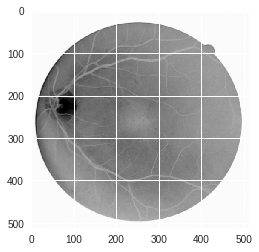

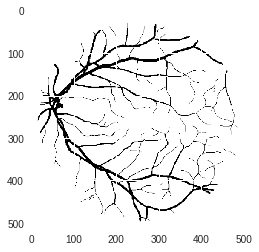

In [93]:
# Training pre-processing
image_paths.sort()
train_input = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    image = cv2.resize(image, (512, 512))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    train_input.append(image)
    
target_paths.sort()
train_target = []
for target_path in target_paths:
    target = cv2.imread(target_path)
    target = cv2.resize(target, (512, 512))
    target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    train_target.append(target)
    
plt.imshow(train_input[0], interpolation='nearest')
plt.show()
plt.imshow(train_target[0], interpolation='nearest')
plt.show()

train_input = np.array(train_input)
train_target = np.array(train_target)

train_input = train_input.reshape(train_input.shape[0], 512, 512, 1)
train_target = train_target.reshape(train_target.shape[0], 512, 512, 1)

train_input = train_input.astype('float32')
train_target = train_target.astype('float32')

train_input/=255
train_target/=255

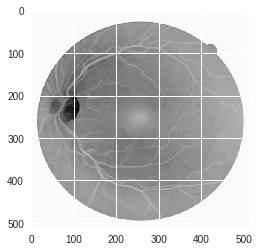

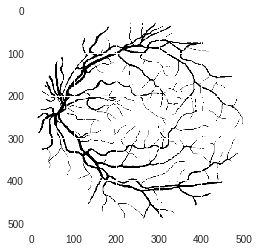

In [94]:
# Testing pre-processing
test_image_paths.sort()
test_input = []
for test_image in test_image_paths:
    image = cv2.imread(test_image)
    image = cv2.resize(image, (512, 512))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    test_input.append(image)
    
test_target_paths.sort()
test_target = []
for target_path in test_target_paths:
    target = cv2.imread(target_path)
    target = cv2.resize(target, (512, 512))
    target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    test_target.append(target)
    
plt.imshow(test_input[0], interpolation='nearest')
plt.show()
plt.imshow(test_target[0], interpolation='nearest')
plt.show()

test_input = np.array(test_input)
test_target = np.array(test_target)

test_input = test_input.reshape(test_input.shape[0], 512, 512, 1)
test_target = test_target.reshape(test_target.shape[0], 512, 512, 1)

test_input = test_input.astype('float32')
test_target = test_target.astype('float32')

test_input/=255
test_target/=255

In [0]:
def unet(height,width,n_ch):
    inputs = Input((height,width,n_ch))
    
    # First set of layers
    down1 = Conv2D(64, (3,3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3,3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2,2))(down1)

    # Second set of layers
    down2 = Conv2D(128, (3,3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3,3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2,2))(down2)

    # Third set of layers
    down3 = Conv2D(256, (3,3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3,3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2,2))(down3)

    # Fourth set of layers
    down4 = Conv2D(512, (3,3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3,3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2,2))(down4)

    # Fifth set of layers
    mid = Conv2D(1024, (3,3), padding='same')(down4_pool)
    mid = BatchNormalization()(mid)
    mid = Activation('relu')(mid)
    mid = Conv2D(1024, (3,3), padding='same')(mid)
    mid = BatchNormalization()(mid)
    mid = Activation('relu')(mid)

    # First up layers
    up4 = UpSampling2D((2,2))(mid)
    up4 = concatenate([down4,up4], axis=3)
    up4 = Conv2D(512, (3,3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3,3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3,3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)

    # Second up layers
    up3 = UpSampling2D((2,2))(up4)
    up3 = concatenate([down3,up3], axis=3)
    up3 = Conv2D(256, (3,3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3,3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3,3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)

    # Third up layers
    up2 = UpSampling2D((2,2))(up3)
    up2 = concatenate([down2,up2], axis=3)
    up2 = Conv2D(128, (3,3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3,3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3,3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)

    # Fourth up layers
    up1 = UpSampling2D((2,2))(up2)
    up1 = concatenate([down1,up1], axis=3)
    up1 = Conv2D(64, (3,3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3,3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3,3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)

    # Output layer
    out = Conv2D(1, (1,1), padding='same')(up1)
    out = Activation('sigmoid')(out)

    model = Model(inputs=inputs, outputs=out)

    model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [96]:
# Run model

EPOCHS=20

model = unet(512,512,1)
#model.summary()

model.fit(train_input, train_target, epochs=EPOCHS, batch_size=1)

Epoch 1/20
20/20 [==============================] - 25s 1s/step - loss: 0.4442 - acc: 0.8105
Epoch 2/20
20/20 [==============================] - 18s 925ms/step - loss: 0.2583 - acc: 0.9035
Epoch 3/20
20/20 [==============================] - 18s 924ms/step - loss: 0.2236 - acc: 0.9103
Epoch 4/20
20/20 [==============================] - 18s 925ms/step - loss: 0.2028 - acc: 0.9130
Epoch 5/20
20/20 [==============================] - 18s 925ms/step - loss: 0.1888 - acc: 0.9145
Epoch 6/20
20/20 [==============================] - 19s 925ms/step - loss: 0.1797 - acc: 0.9157
Epoch 7/20
20/20 [==============================] - 19s 925ms/step - loss: 0.1764 - acc: 0.9155
Epoch 8/20
20/20 [==============================] - 19s 925ms/step - loss: 0.1641 - acc: 0.9170
Epoch 9/20
20/20 [==============================] - 19s 925ms/step - loss: 0.1593 - acc: 0.9182
Epoch 10/20
20/20 [==============================] - 19s 926ms/step - loss: 0.1503 - acc: 0.9191
Epoch 11/20
20/20 [=======================

In [0]:
def img2bin(img):
    img_new = img.copy() # Make copy instead of changing origianl list
    rows, cols = img_new.shape
    for row in range(rows):
        for col in range(cols):
            if img_new[row][col]*255 > 215:
                img_new[row][col] = 1
            else:
                img_new[row][col] = 0
    return img_new.astype(int)

def iou(pred,target):
    intersection = pred*target
    notTrue = 1 - target
    union = target + (notTrue * pred)
    return np.sum(intersection)/np.sum(union)


def avg_iou(preds,targets):

    assert len(preds) == len(targets)
    
    targets = []
    for img in train_target:
        targets.append(img2bin(img))

    preds = []
    for img in train_pred:
        preds.append(img2bin(img))

    pred_targets = [(preds[i], targets[i]) for i in range(len(preds))]

    train_iou = []
    for pred, target in pred_targets:
        train_iou.append(iou(pred,target))

    return sum(train_iou)/len(preds)

In [0]:
# training prediction
train_pred = model.predict(train_input)

# testing prediction
test_pred = model.predict(test_input)

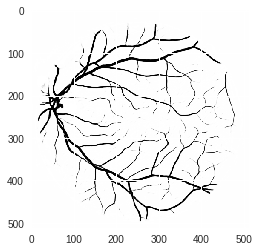

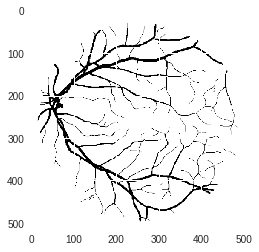

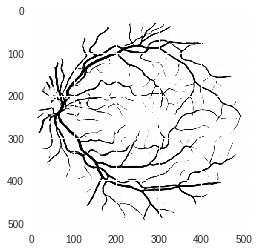

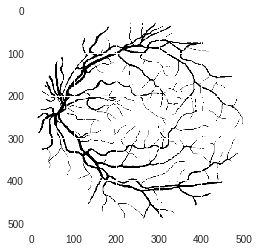

In [89]:
train_target = train_target.reshape(train_target.shape[0], 512, 512)
test_target = test_target.reshape(test_target.shape[0], 512, 512)
train_pred = train_pred.reshape(train_pred.shape[0], 512, 512) 
test_pred = test_pred.reshape(test_pred.shape[0], 512, 512) 

plt.imshow(train_pred[0], interpolation='nearest')
plt.show()

plt.imshow(train_target[0], interpolation='nearest')
plt.show()

plt.imshow(test_pred[0], interpolation='nearest')
plt.show()

plt.imshow(test_target[0], interpolation='nearest')
plt.show()

In [90]:
# check iou of test and train data

train_sum = 0
test_sum = 0
for i in range(len(train_pred)):
    print("image: " + str(i) "...")
    train_iou = iou(img2bin(train_pred[i]), img2bin(train_target[i]))
    test_iou = iou(img2bin(test_pred[i]), img2bin(test_target[i]))               
    train_sum += train_iou
    test_sum += test_iou
    
print("train_sum: ")
print(train_sum/len(train_pred))

print("test_sum: ")
print(test_sum/len(train_pred))

#print(avg_iou(test_pred,test_target))

image: 0
image: 1
image: 2
image: 3
image: 4
image: 5
image: 6
image: 7
image: 8
image: 9
image: 10
image: 11
image: 12
image: 13
image: 14
image: 15
image: 16
image: 17
image: 18
image: 19
0.6266595168898591
0.5791984592949055
